In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
min([len(word) for word in words])

2

In [5]:
max([len(word) for word in words])

15

In [6]:
len(words)

32033

In [7]:
b={}
for word in words:
    chs = ['<S>'] + list(word) + ['<E>']
    for ch1, ch2 in zip(chs,chs[1:]):
        bigram = (ch1,ch2)
        b[bigram] = b.get(bigram,0)+1


In [8]:
sorted(b.items(), key=lambda x : -x[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [9]:
import torch

In [10]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [11]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [12]:
for word in words:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1,ix2]+=1

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

(-0.5, 26.5, 26.5, -0.5)

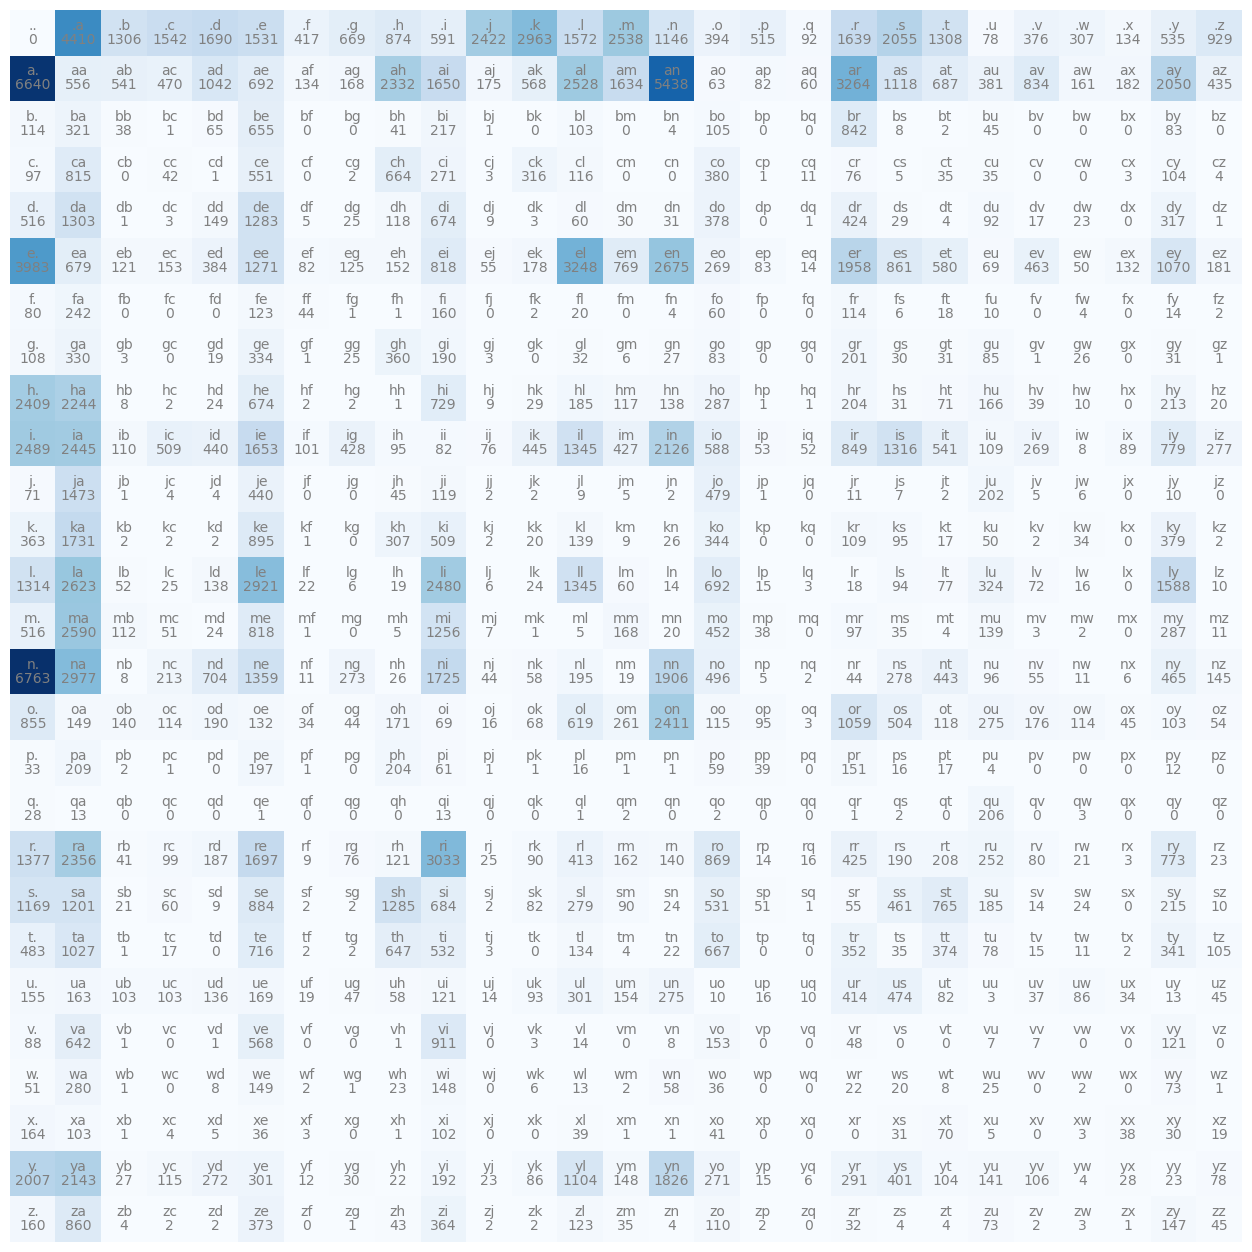

In [14]:
plt.figure(figsize=(16,16))
plt.imshow(N,cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i,chstr,ha='center',va='bottom',color='gray')
        plt.text(j,i,N[i,j].item(),ha='center',va='top',color='gray')
plt.axis('off')

In [15]:
P = (N+1).float()

In [16]:
P /= P.sum(1,keepdim=True) # we keep dim to brodcast for rows(27,27 by 27,1) not for columns(27,27 by 1,27)

In [17]:
P[:,0].sum() # columns are not normalized

tensor(3.0023)

In [18]:
P[0].sum() # rows are normalized

tensor(1.)

In [19]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        p=P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0: break

    print(''.join(out))  

junide.
janasah.
p.
cony.
a.


In [20]:
log_likelihood=0.0
n=0
for word in words:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        log_prob = torch.log(prob)
        log_likelihood+=log_prob
        n+=1
nll = -log_likelihood
print(f'{nll/n=}')

nll/n=tensor(2.4544)


## **Neural Network Approch**

In [21]:
# creating training dataset
xs = []
ys = []
for word in words[:1]:
    word = '.' + word + '.'
    for ch1,ch2 in zip(word,word[1:]):
        id1 = stoi[ch1]
        id2 = stoi[ch2]
        xs.append(id1)
        ys.append(id2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)    

In [22]:
import torch.nn.functional as F

In [23]:
xenc = F.one_hot(xs,num_classes=27)

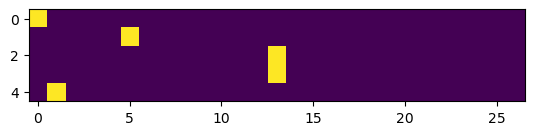

In [24]:
plt.imshow(xenc)

In [25]:
xenc.dtype

torch.int64

In [26]:
xenc = xenc.float()
xenc.dtype

torch.float32

In [27]:
W = torch.randn((27,27))

In [28]:
(xenc @ W)[3,13] 

tensor(-0.6837)

In [29]:
(xenc[3] * W[:,13] ).sum()

tensor(-0.6837)

In [30]:
logits = (xenc @ W)# predict log counts

# Softmax
counts = logits.exp()# counts, equivalent to N
probs = counts / counts.sum(1,keepdims=True) # Probablities for next character

In [31]:
probs.shape

torch.Size([5, 27])

In [32]:
nlls = torch.zeros(5)
for i in range(5):
    x = xs[i].item()
    y = ys[i].item()
    p = probs[i,y]
    logp = torch.log(p)
    nll = -logp
    nlls[i] = nll

nlls.mean()

tensor(3.5216)

### Organizing Code

In [33]:
# creating dataset
xs = []
ys = []
for word in words:
    word = '.'+word+'.'
    for ch1, ch2 in zip(word,word[1:]):
        id1 = stoi[ch1]
        id2 = stoi[ch2]
        xs.append(id1)
        ys.append(id2)
      
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xenc = F.one_hot(xs,num_classes=27).float()
num = xs.nelement()
num

228146

In [34]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27),generator=g,requires_grad=True)

In [35]:
for k in range(100):
    # forward pass
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1,keepdims=True)
    loss = -probs[torch.arange(num),ys].log().mean() + 0.01 * (W**2).mean()
    if (k%100 == 0):
        print(f'loss= {loss.item():.3f}')
    # backward pass
    W.grad =None
    loss.backward()
    # update 
    W.data += -50 * W.grad    

loss= 3.769


In [36]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
    # before
        # p=P[ix]
    # now
        ixenc = F.one_hot(torch.tensor([ix]),num_classes=27).float()
        ilogits = ixenc @ W
        icounts = ilogits.exp()
        p = icounts / icounts.sum(1,keepdims=True)
        ix = torch.multinomial(p,num_samples=1,replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0: break

    print(''.join(out)) 

junide.
janasah.
p.
cfay.
a.


## MLP Language Model

In [37]:
block_size = 3
# create the dataset
def create_dataset(words):
    X,Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:]+[ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1= int(len(words)*.8)
n2= int(len(words)*.9)
Xtr,Ytr = create_dataset(words[:n1])
Xdev,Ydev = create_dataset(words[n1:n2])
Xtest,Ytest = create_dataset(words[n2:])

In [38]:
Xtr.shape, Ytr.shape, Xdev.shape, Xtest.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22866, 3]))

In [39]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10),generator=g)
W1 = torch.randn((30,100),generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27),generator=g)
b2 = torch.rand(27,generator=g)
paramaters = [C,W1,b1,W2,b2]

In [40]:
sum([p.nelement() for p in paramaters])

6097

In [41]:
for p in paramaters:
    p.requires_grad = True

In [42]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [43]:
lri=[]
lossi=[]
stepi=[]

In [44]:
# training loop
for i in range(10000):
    ix = torch.randint(0,Xtr.shape[0],(32,))
    # forward pass 
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30)@W1+b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr[ix])
    
    # bckward pass 
    for p in paramaters:
        p.grad = None
    loss.backward()
    # update 
#     lr = lrs[i]
    lr = 0.09
    for p in paramaters:
        p.data += -lr*p.grad
    
    # track state
#     lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)
    
print('loss= ',loss.item())

loss=  2.3490052223205566


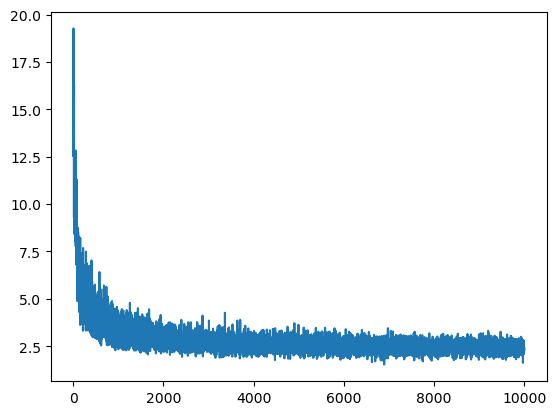

In [45]:
plt.plot(stepi,lossi)

In [46]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30)@W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.4039, grad_fn=<NllLossBackward0>)

In [47]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30)@W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.4089, grad_fn=<NllLossBackward0>)

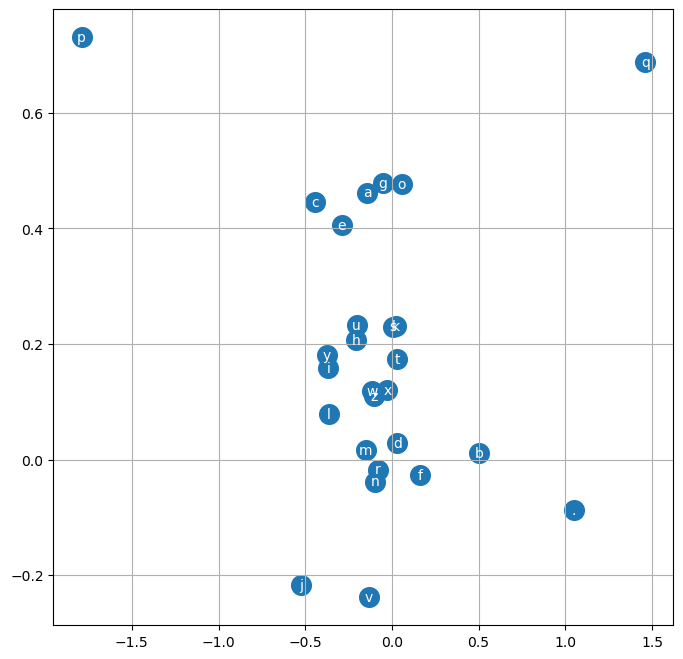

In [48]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [49]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(5):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1,30)@W1+b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,replacement=True, generator=g).item()
        context = context[1:]+[ix]
        out.append(itos[ix])
        if ix == 0: break

    print(''.join(out)) 

junide.
jakaritha.
corr.
emin.
kai.


## Activations & Gradients, BatchNorm

In [50]:
n_embd=10
n_hidden=200
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd)          ,generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g) *(5/3)/(n_embd*block_size)**0.5
# b1 = torch.randn(n_hidden                    ,generator=g) *0.01
W2 = torch.randn((n_hidden,vocab_size)       ,generator=g) *0.01
b2 = torch.rand(vocab_size                   ,generator=g) *0

# BatchNorm parameters
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,W1,W2,b2, bngain,bnbias]

print(sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

12097


In [51]:
max_steps = 200000
batch_size = 32
lossi = []

# training loop
for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0,Xtr.shape[0],(32,))
    Xb,Yb = Xtr[ix], Ytr[ix]
    
    # forward pass 
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1  # b1
    # BatchNorm 
    bnmeani = hpreact.mean(0,keepdims=True)
    bnstdi = hpreact.std(0,keepdims=True)
    hpreact = bngain*(hpreact- bnmeani)/ bnstdi  + bnbias
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running +0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    # Non-Linearity    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Yb)
    
    # bckward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    # update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    # track state
    if i%10000==0:
        print(f'{i:7d} {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
print('loss= ',loss.item())


      0  200000: 3.3134
  10000  200000: 2.2391
  20000  200000: 2.2091
  30000  200000: 2.1005
  40000  200000: 2.4538
  50000  200000: 2.1562
  60000  200000: 2.5170
  70000  200000: 2.4596
  80000  200000: 2.4673
  90000  200000: 1.8260
 100000  200000: 2.4195
 110000  200000: 1.8776
 120000  200000: 1.9732
 130000  200000: 2.3490
 140000  200000: 2.4625
 150000  200000: 2.0332
 160000  200000: 2.2178
 170000  200000: 2.1210
 180000  200000: 1.9783
 190000  200000: 1.8654
loss=  2.0664687156677246


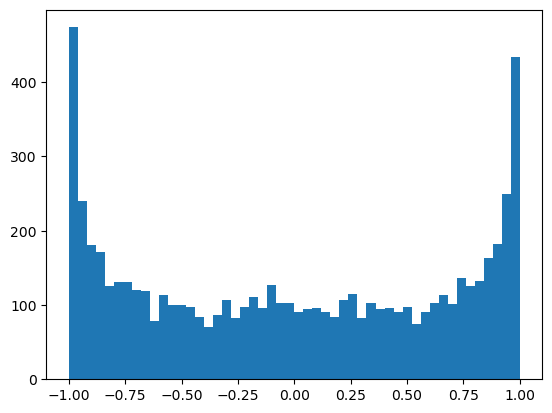

In [52]:
plt.hist(h.view(-1).tolist(),50);

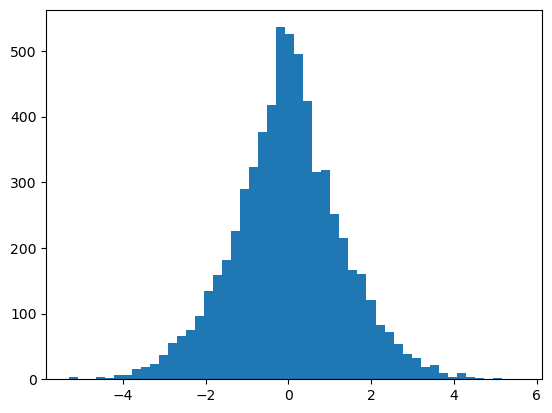

In [53]:
plt.hist(hpreact.view(-1).tolist(),50);

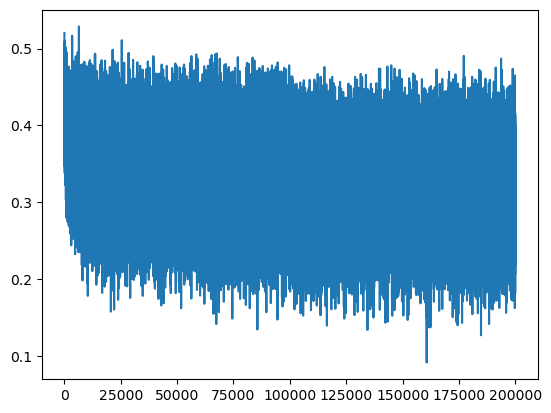

In [54]:
plt.plot(lossi)

In [55]:
@torch.no_grad()
def split_loss(split):
    x,y ={
        'train':(Xtr,Ytr),
        'dev':(Xdev,Ydev),
        'test':(Xtest,Ytest)        
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 #+ b1
    hpreact = bngain*(hpreact- bnmean_running)/ bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())
    
split_loss('train')
split_loss('dev')    

train 2.069687604904175
dev 2.1091248989105225


In [56]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(5):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1,30)@W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,replacement=True, generator=g).item()
        context = context[1:]+[ix]
        out.append(itos[ix])
        if ix == 0: break

    print(''.join(out)) 

junidh.
takayah.
prishawn.
brieshirltorianshthryks.
teth.


###  Pytorch-ifying the code 

In [57]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]


with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [58]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])


      0/ 200000: 3.2870
  10000/ 200000: 2.3273
  20000/ 200000: 2.1019
  30000/ 200000: 1.9020
  40000/ 200000: 2.1643
  50000/ 200000: 2.1520
  60000/ 200000: 1.7767
  70000/ 200000: 2.1514
  80000/ 200000: 2.3802
  90000/ 200000: 1.9338
 100000/ 200000: 2.3943
 110000/ 200000: 2.1508
 120000/ 200000: 2.1813
 130000/ 200000: 2.0889
 140000/ 200000: 1.8096
 150000/ 200000: 1.9132
 160000/ 200000: 1.9793
 170000/ 200000: 1.9654
 180000/ 200000: 2.2462
 190000/ 200000: 1.9601


layer 2 (      Tanh): mean +0.01, std 0.70, saturated: 17.69%
layer 5 (      Tanh): mean -0.02, std 0.75, saturated: 21.62%
layer 8 (      Tanh): mean +0.01, std 0.78, saturated: 21.47%
layer 11 (      Tanh): mean +0.01, std 0.79, saturated: 23.25%
layer 14 (      Tanh): mean +0.02, std 0.81, saturated: 25.47%


Text(0.5, 1.0, 'activation distribution')

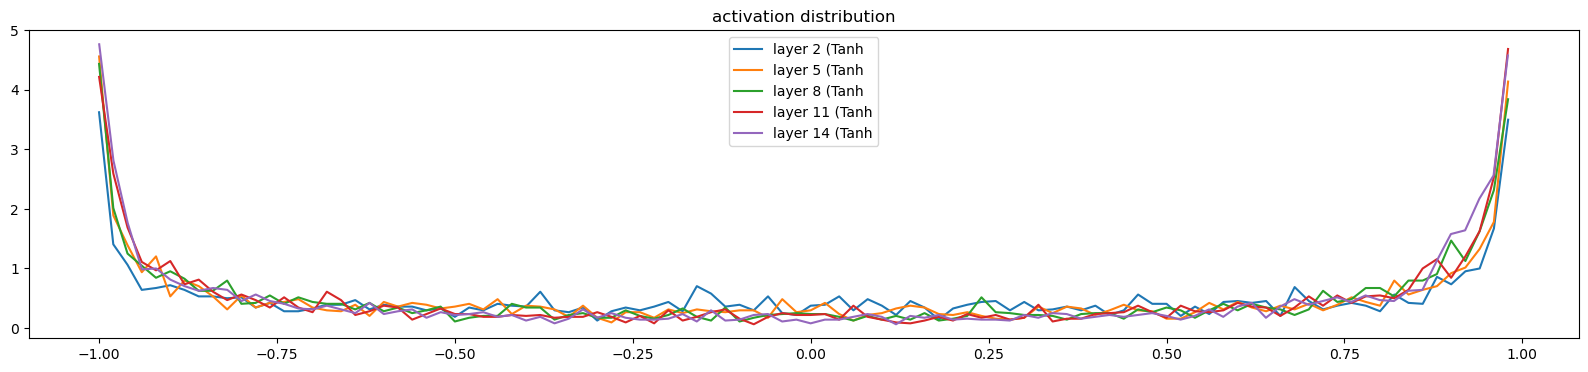

In [59]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.682874e-03
layer 5 (      Tanh): mean +0.000000, std 3.489859e-03
layer 8 (      Tanh): mean -0.000000, std 3.605006e-03
layer 11 (      Tanh): mean -0.000000, std 3.117708e-03
layer 14 (      Tanh): mean -0.000000, std 3.502831e-03


Text(0.5, 1.0, 'gradient distribution')

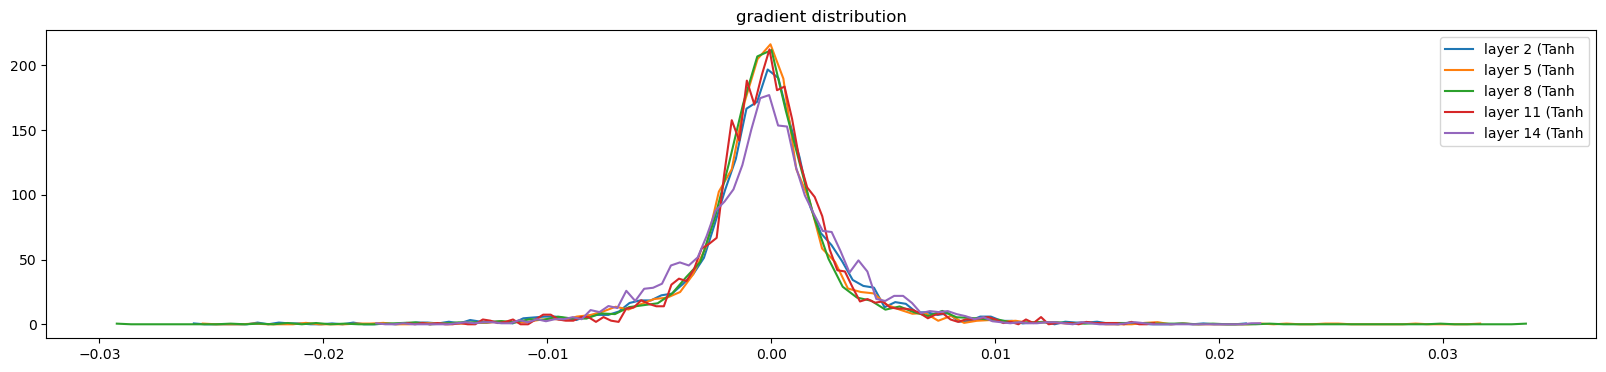

In [60]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.841533e-02 | grad:data ratio 1.619698e-02
weight  (30, 100) | mean -0.000044 | std 9.194894e-03 | grad:data ratio 2.290735e-02
weight (100, 100) | mean +0.000048 | std 5.665788e-03 | grad:data ratio 2.324928e-02
weight (100, 100) | mean +0.000033 | std 5.441762e-03 | grad:data ratio 2.262053e-02
weight (100, 100) | mean +0.000047 | std 5.277572e-03 | grad:data ratio 2.292431e-02
weight (100, 100) | mean +0.000001 | std 4.858515e-03 | grad:data ratio 2.253536e-02
weight  (100, 27) | mean -0.000082 | std 7.756870e-03 | grad:data ratio 2.193141e-02


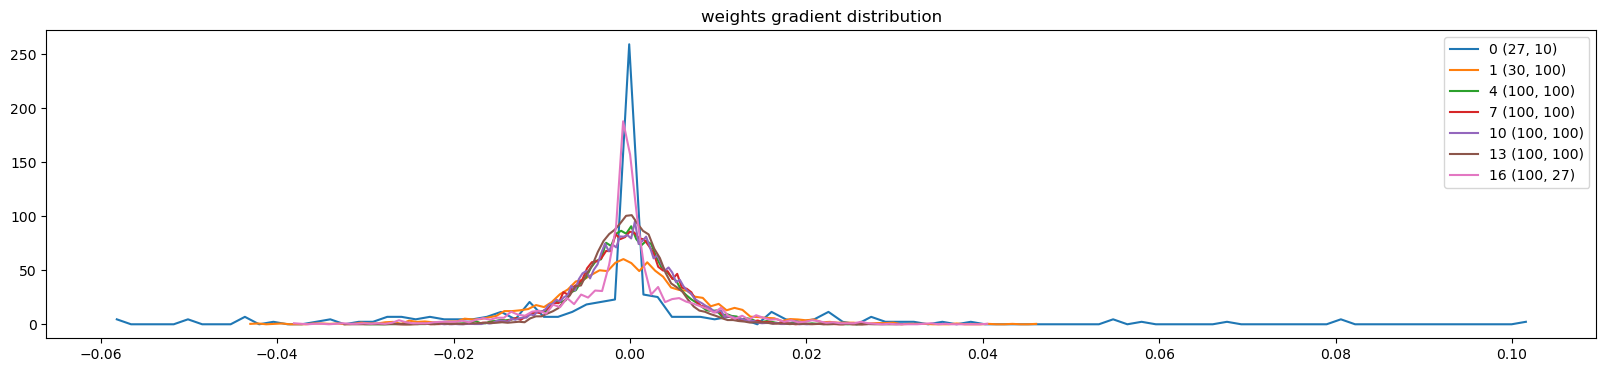

In [61]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

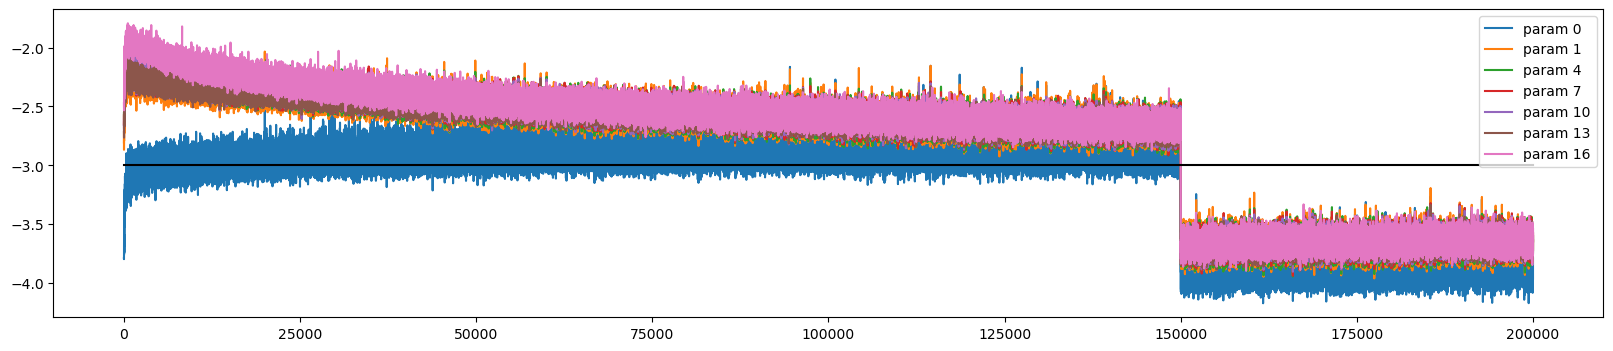

In [62]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [64]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.999863624572754
val 2.077087879180908


In [65]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

montaylynn.
see.
mad.
rylla.
emmasiendra.
gradee.
daelin.
shi.
jenneden.
estanaraelyn.
malaia.
nosalbergiaghiel.
kinjo.
jennix.
teriffuna.
geder.
yarun.
eli.
kayshaykella.
halisa.


In [66]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [67]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [68]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953054189682007
